# Module 6: Purple Data Analysis

Greg Lee
<br>u0890227
<br>04.09.20

This notebook represents an exploration into time series data collected from the purpleair website. These analysis aim to examine a subset of experimental data collected for one day (4/7/20) at hourly measurements. This analysis acts an intial foray into the data which will be used for the final project.

**PurpleAir**
<br>PurpleAir sensors measure airborne particulate matter (PM). Particulate matter describes solid particles suspended in air; this includes dust, smoke, and other organic and inorganic particles. PurpleAir sensors use laser particle counters to count the number of particles by particle sizes 0.3, 0.5, 1, 2.5, 5, and 10 μm, and use the count data to calculate mass concentrations of PM1.0, PM2.5, and PM10. 

Some information regarding legacy data: 

| Abbreviation | Explanation |
|------|------|
|ID: | PurpleAir Sensor|
|Parent ID: | The PurpleAir sensor ID of the "parent" entry in the case of Channel B|
|THINGSPEAK_PRIMARY_ID |The Thingspeak channel ID for primary data of this sensor|
|THINGSPEAK_PRIMARY_ID_READ_KEY | The Thingspeak read key for primary data of this sensor |
|Label| The "name" that appears on the map for this sensor|
|Lat| Latitude position info|
|Lon|Longitude position info|
|PM2_5Value|Current PM2.5 value|
|State|Unused variable|
|Type|Sensor type (PMS5003, PMS1003, BME280 etc)|
|Hidden|Hide from public view on map: true/false|
|Flag|Data flagged for unusually high readings|
|DEVICE_BRIGHTNESS|LED brightness (if hardware is present)|
|isOwner|Currently logged in user is the sensor owner|
|A_H|true if the sensor output has been downgraded or marked for attention due to suspected hardware|
|temp_f|Current temperature in F|
|humidity|Current humidity in %|
|pressure|Current pressure in Millibars|
|AGE|Sensor data age (when data was last received) in minutes|
|THINGSPEAK_SECONDARY_ID|The Thingspeak channel ID for secondary data of this sensor|
|THINGSPEAK_SECONDARY_ID_READ_KEY|The Thingspeak read key for secondary data of this sensor|
|LastSeen|Last seen data time stamp in UTC|
|Version|Current version of sensor firmware|
|LastUpdateCheck|Last update checked at time stamp in UTC|
|Uptime|Sensor uptime in seconds|
|RSSI|Sensor's WiFi signal strength in dBm|
|Stats|Statistics for PM2.5|


### Question

How do the PM levels change throughout Utah over a 24 hour period? 

# Libraries:


In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import os

#Date
from datetime import datetime
import pytz

#Geography
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes
import contextily as ctx #Basemaps 

# Import the Data

All data presented here was collected utilizing an airflow system for JSON information collection at hourly rates. More detail will be given for the final project on this process. Here we grab the data for a 24 hr. period starting on April 8th at 12:00AM MST.

In [10]:
directory = '/home/boogie2/external/tiny_tower_2/purpleair_data/'
data_direct = []

#Create a directory of the data
for filename in os.listdir(directory):
    
    #append the path to the list
    data_direct.append(os.path.join(directory, filename))
    
    #sort the data
    data_direct = sorted(data_direct)

In [12]:
#Grab the legacy data for April 8th
leg_dir = []

for entries in data_direct:
        
    #Collect the legacy data    
    if "legacy_04_08" in str(entries):
        leg_dir.append(entries)

print("The legacy directory has {0} entries".format(len(leg_dir)))

The legacy directory has 24 entries


In [14]:
#These numbers seem reasonable for 24 hrs. Let's append to a pandas dataframe

#This function will help put the data into a larger dataframe
def concater(temp_dir):
    data = []

    for dirs in temp_dir:
        temp_df = pd.read_pickle(dirs)
        
        if 'legacy' in dirs:
            temp_df['Time']= dirs.split('legacy_')[1].split('.pkl')[0]
            
        data.append(temp_df)

    return(pd.concat(data))

legacy_df = concater(leg_dir)
legacy_df.head(2)

,mapVersion,baseVersion,mapVersionString,ID,Label,DEVICE_LOCATIONTYPE,THINGSPEAK_PRIMARY_ID,THINGSPEAK_PRIMARY_ID_READ_KEY,THINGSPEAK_SECONDARY_ID,THINGSPEAK_SECONDARY_ID_READ_KEY,...,temp_f,pressure,AGE,Stats,ParentID,Flag,A_H,Voc,Ozone1,Time
0,0.4,7,,14633,Hazelwood canary,outside,559921,CU4BQZZ38WO5UJ4C,559922,D0YNZ1LM59LL49VQ,...,63,1008.75,1,"{""v"":0.58,""v1"":0.58,""v2"":0.61,""v3"":0.72,""v4"":1...",NaN,NaN,NaN,NaN,NaN,04_08_00_00
1,0.4,7,,14634,Hazelwood canary B,NaN,559923,DULWDNCI9M6PCIPC,559924,EY2CNMYRUZHDW1AL,...,NaN,NaN,1,"{""v"":0.0,""v1"":0.05,""v2"":0.08,""v3"":0.13,""v4"":0....",14633.0,1.0,NaN,NaN,NaN,04_08_00_00


In [15]:
#PurpleAir Data represents sensors from around the country. Here we select Utah by a bounding box. 
#NOTE: a little bit of Wyoming is included!

ut_leg_df = legacy_df[(legacy_df['Lat']>=37.043937)&
          (legacy_df['Lat']<=41.98959) &
         (legacy_df['Lon']<= -108.936278) &
         (legacy_df['Lon']>= -113.989989)]

In [18]:
#We need to set the date and time as an object in MST for better ease of analysis
ut_leg_df = ut_leg_df.reset_index(drop=True)
ut_leg_df['Time'] = ut_leg_df['Time'].apply(lambda x: 
                                       datetime.strptime(str('20_'+x),
                                                         "%y_%m_%d_%H_%M"))

#Set the timezone
tz = pytz.timezone("America/Denver")
ut_leg_df['Time'] = ut_leg_df['Time'].apply(lambda x: tz.localize(x))

# Data Description:

In [20]:
print("Purpleair Utah Legacy Data Shape {0} x {1}".format(ut_leg_df.shape[0],
                                        ut_leg_df.shape[1]))

Purpleair Utah Legacy Data Shape 24650 x 28


In [23]:
print("Total number of sensors in the data: {0}".format(ut_leg_df['ID'].drop_duplicates().shape[0]))

Total number of sensors in the data: 1030


In [26]:
print('Minimum Date: {0}'.format(ut_leg_df['Time'].min()))
print('Maximum Date: {0}'.format(ut_leg_df['Time'].max()))

Minimum Date: 2020-04-08 00:00:00-06:00
Maximum Date: 2020-04-08 23:00:00-06:00


In [22]:
#What do the nan's in the data look like? 
ut_leg_df.isna().sum().sort_values()

mapVersion                              0
AGE                                     0
isOwner                                 0
Hidden                                  0
Lon                                     0
Lat                                     0
THINGSPEAK_SECONDARY_ID_READ_KEY        0
THINGSPEAK_SECONDARY_ID                 0
LastSeen                                0
THINGSPEAK_PRIMARY_ID                   0
baseVersion                             0
THINGSPEAK_PRIMARY_ID_READ_KEY          0
mapVersionString                        0
ID                                      0
Time                                    0
Label                                   0
PM2_5Value                           1401
Stats                                1401
Type                                12013
humidity                            12517
pressure                            12517
temp_f                              12517
ParentID                            12541
DEVICE_LOCATIONTYPE               

In [27]:
ut_leg_df.dtypes

mapVersion                                                  object
baseVersion                                                 object
mapVersionString                                            object
ID                                                           int64
Label                                                       object
DEVICE_LOCATIONTYPE                                         object
THINGSPEAK_PRIMARY_ID                                       object
THINGSPEAK_PRIMARY_ID_READ_KEY                              object
THINGSPEAK_SECONDARY_ID                                     object
THINGSPEAK_SECONDARY_ID_READ_KEY                            object
Lat                                                        float64
Lon                                                        float64
PM2_5Value                                                  object
LastSeen                                                     int64
Type                                                        ob

In [36]:
#Recast data types
ut_leg_df = ut_leg_df.astype({'PM2_5Value': 'float64',
                 'humidity':'float64',
                 'temp_f': 'float64',
                 'pressure': 'float64',
                 'Ozone1': 'float64'})

In [37]:
ut_leg_df.describe()

,ID,Lat,Lon,PM2_5Value,LastSeen,isOwner,humidity,temp_f,pressure,AGE,ParentID,Flag,Voc,Ozone1
count,24650.000000,24650.000000,24650.000000,23249.000000,2.465000e+04,24650.0,12133.000000,12133.000000,12133.000000,24650.000000,12109.000000,5372.000000,216.000000,48.000000
mean,19388.583489,40.606641,-111.844952,23.544952,1.586313e+09,0.0,29.172999,66.358444,850.285616,900.418661,19630.476257,0.995532,231.259259,1.808750
std,14195.169807,0.608761,0.364856,320.835997,2.969742e+05,0.0,12.999993,13.047815,32.440339,4930.559437,14143.647074,0.066697,224.883137,0.345325
min,20.000000,37.052847,-113.986114,0.000000,1.583975e+09,0.0,3.000000,26.000000,633.880000,0.000000,201.000000,0.000000,0.000000,1.190000
25%,6348.000000,40.475832,-111.922076,0.560000,1.586344e+09,0.0,19.000000,55.000000,845.240000,0.000000,6434.000000,1.000000,52.250000,1.520000
50%,16012.000000,40.672575,-111.860698,1.450000,1.586365e+09,0.0,27.000000,67.000000,858.150000,1.000000,16263.000000,1.000000,163.500000,1.835000
75%,30942.000000,40.774129,-111.760208,2.810000,1.586387e+09,0.0,37.000000,77.000000,867.260000,1.000000,30953.000000,1.000000,356.750000,2.085000
max,49256.000000,41.764022,-109.496450,6147.830000,1.586408e+09,0.0,100.000000,110.000000,924.230000,40312.000000,49255.000000,1.000000,1060.000000,2.440000


/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


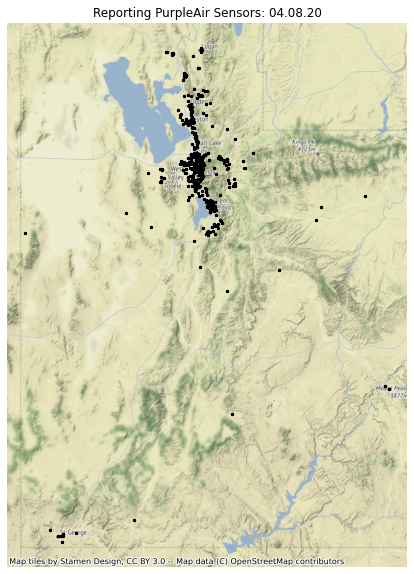

In [63]:
#Visualization of sensor location
sensor_set = ut_leg_df.drop_duplicates(subset='ID', keep="first")

sensor_gdf = gpd.GeoDataFrame(sensor_set, geometry=gpd.points_from_xy(sensor_set.Lon, 
                                                                      sensor_set.Lat))
sensor_gdf.crs = {'init' :'epsg:4326'}
sensor_gdf = sensor_gdf.to_crs({'init': 'epsg:3857'})

#Plotting
fig, ax = plt.subplots(1,1,figsize = (10,10))
sensor_gdf.plot(ax = ax,color = 'k',markersize = 5,marker='o')
plt.title("Reporting PurpleAir Sensors: 04.08.20")
plt.axis('off')
ctx.add_basemap(ax)

**Conclusions**
1. PM2.5 data is missing for a small portion of the data. For these sensors, let's try and do some interpolation. 
2. Humidity, pressure, temperature all seem to be useful pieces of information. Although almost 50% of the data is missing these values... Let's try some interpolation for these values although this will definetly incorperate some error into the model. Note, since most of these sensors are typically located within urban settings, this may skew observations towards those conditions. 
3. While it would be interesting to look into Ozone and Voc's, there are too many missing values to make interpolation relevant. These features will be dropped. 


4. The average temperature in Utah on April 8th was 66 degrees farenheight
5. TThe average age of sensor is 900 days ~ 3 years
6. The average humidity was 29.172 %H20
7. The average PM25 value was 23.544 in EPA PM2.5 AQI values

# Dealing with Null Values